In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

from IPython.display import HTML
from matplotlib import animation, rc
from matplotlib import pyplot as plt 

# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()

Using TensorFlow backend.


Our first step is to list out the files we have, and then grab some image.

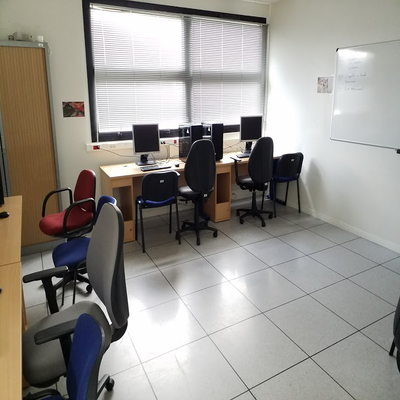

In [38]:
fn = "images/salle.jpg";
img=Image.open(fn); img
new_width  = 400
new_height = 400
img = img.resize((new_width, new_height), Image.ANTIALIAS); img

In [39]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [40]:
img_arr = preproc(np.expand_dims(np.array(img), 0)[:,:,:,:3])
shp = img_arr.shape

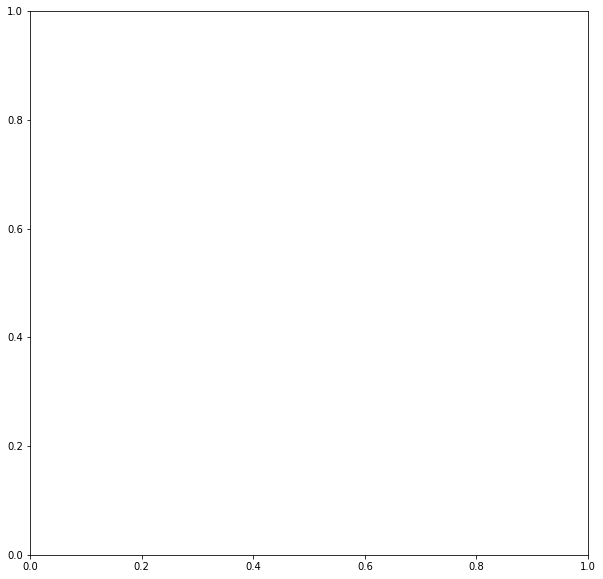

In [41]:
model = VGG16_Avg(include_top=False,input_shape = shp[1:])
layer = model.get_layer('block2_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
    
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

def solve_image(eval_obj, niter, x, noise):
    last_min_val = 100000000
    imsave("results/res_at_iteration_{}.png".format(0), noise)
    
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave("results/res_at_iteration_{}.png".format(i+1), deproc(x.copy(), shp)[0])
        if last_min_val == min_val:
            break
        else:
            last_min_val = min_val        
    return x

fig, ax = plt.subplots(figsize=(10,10))
def animate(i): ax.imshow(Image.open("results/res_at_iteration_{}.png".format(i)))
    
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

Next we need to generate a random image.

In [42]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
show_noise = (x[0] + 0.025)/0.05

/home/brain/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 4573.61865234


/home/brain/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:29: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1134.43737793
Current loss value: 266.994812012
Current loss value: 68.6783828735
Current loss value: 25.7747383118
Current loss value: 15.9162359238
Current loss value: 12.9184236526
Current loss value: 11.5658378601
Current loss value: 10.7923965454
Current loss value: 9.84435749054


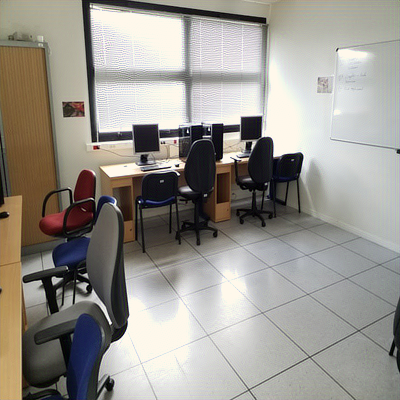

In [43]:
iterations=10
x = solve_image(evaluator, iterations, x,show_noise)
Image.open('results/res_at_iteration_10.png')

The optimizer first focuses on the important details of the bird, before trying to match the background.

In [44]:
anim = animation.FuncAnimation(fig, animate, frames=11, interval=200)
HTML(anim.to_html5_video())

### Recreate style

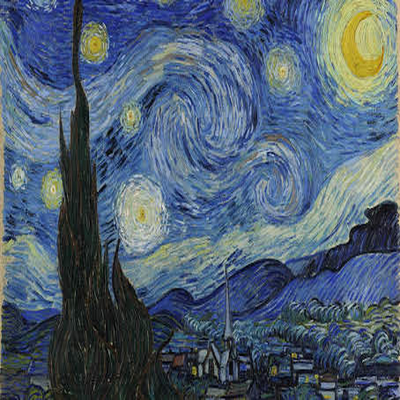

In [45]:
style = Image.open('images/starry_night.jpeg')
new_width  = 400
new_height = 400
style = style.resize((new_width, new_height), Image.ANTIALIAS)
style

In [46]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape
outputs = {l.name: l.output for l in model.layers}
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): 
    return metrics.mse(gram_matrix(x), gram_matrix(targ))

loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [47]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

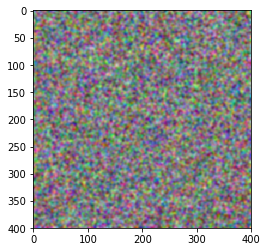

In [48]:
show_noise = (x[0]+np.abs(x[0].min()))/(2*x[0].max())
plt.imshow(show_noise)

In [49]:
x = solve_image(evaluator, iterations, x,show_noise)

/home/brain/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 8160.56982422


/home/brain/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:29: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 348.382019043
Current loss value: 153.800506592
Current loss value: 109.20664978
Current loss value: 78.4128646851
Current loss value: 58.8530044556
Current loss value: 46.0532302856
Current loss value: 36.4071083069
Current loss value: 26.7968006134
Current loss value: 19.8509864807


Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning.

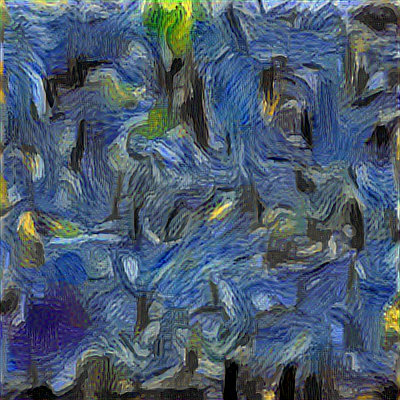

In [50]:
Image.open('results/res_at_iteration_9.png')

In [51]:
anim = animation.FuncAnimation(fig, animate, frames=11, interval=200)
HTML(anim.to_html5_video())

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

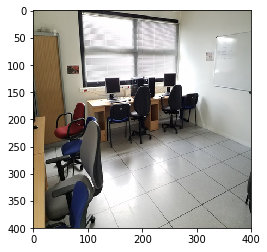

In [52]:
w,h = style.size
content_arr = img_arr[:,:h,:w]
plot_arr(content_arr)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [53]:
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
content_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]


In [54]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [55]:
content_model = Model(model.input, content_layers)
content_targs = [K.variable(o) for o in content_model.predict(content_arr)]

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [56]:
#style_wgts = [0.05,0.2,0.2,0.25,0.3]
content_wgts = [1/(400*len(content_layers))]*len(content_layers)
style_wgts = [1/len(style_layers)]*len(style_layers)

In [57]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += sum(metrics.mse(l1[0], l2[0])*w
           for l1,l2,w in zip(content_layers, content_targs, content_wgts))
#loss += metrics.mse(content_layer, content_targ)/1
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [58]:
evaluator = Evaluator(transfer_fn, shp)

In [59]:
iterations=20
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])
show_noise = (x[0]+np.abs(x[0].min()))/(2*x[0].max())
#src.copy()#

In [ ]:
x = solve_image(evaluator, iterations, x,show_noise)

/home/brain/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1672.85168457


/home/brain/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:29: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 136.819793701
Current loss value: 94.6296234131
Current loss value: 76.0258026123
Current loss value: 63.9079589844
Current loss value: 56.4922447205
Current loss value: 51.4623794556
Current loss value: 47.8104095459
Current loss value: 45.3441238403
Current loss value: 43.4348258972
Current loss value: 41.7903175354
Current loss value: 40.5314674377
Current loss value: 39.6973419189
Current loss value: 38.8724212646
Current loss value: 38.3171920776
Current loss value: 37.7439193726


In [ ]:
Image.open('results/res_at_iteration_20.png')

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=21, interval=200)
HTML(anim.to_html5_video())